# ML802 Advanced Machine Learning

## Week 3 - Dealing with Adversarial Example

**Semester 1, 2024**

**Objectives:**
* To understand the vulnerability and improve the robustness of the model when facing an adversarial example that wishes to fool you.
* To implement the algorithm Fast Gradient Sign Method (FGSM) to generate adversarial examples.
* To implement the algorithm Projected Gradient Descent (PGD) to evaluate the model robustness.
* To implement the algorithm FGSM-AT to train a robust model.

**Instructions:**

* Exercises to be completed on IPython notebook such as: 
   * Ipython 3 (Jupyter) notebook installed on your computer http://jupyter.org/install (you need to have Python installed first https://docs.python.org/3/using/index.html )
   * Web-based Ipython notebooks such as Google Colaboratory https://colab.research.google.com/ 
   
* If you are using Jupyter installed on your computer, Go to File->Open. Drag and drop the "week3_tutorial.ipynb" file to the home interface and click upload. 
* If you are using Google Colaboratory, Click File->Upload notebook, and and upload the "week3_tutorial.ipynb" file
* To run the cell, you can press Ctrl-Enter or hit the Play button at the top.
* Complete all exercises marked with **TODO**.

Lecturer: Tongliang Liu

Tutor: 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

## 1. Adversarial Attack - Implement and Visualization the adversarial example generated by FGSM

### 1.1 Standard Traininig

To evaluate the robustness of a standard model defence against adversarial attack, we first trained a model on the MNIST dataset for 10 epochs.

In [2]:
# LeNet Model definition
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

def mnist_net():
    model = nn.Sequential(
        nn.Conv2d(1, 16, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride=2, padding=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(32*7*7,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    return model

# MNIST training dataset and dataloader declaration
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=100, shuffle=True)

# Define what device we are using
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

model = mnist_net().to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-4)
lr_steps = 10 * len(train_loader)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0, max_lr=5e-3, step_size_up=lr_steps / 2, step_size_down=lr_steps / 2)

for epoch in range(10):
    train_loss = 0
    train_acc = 0
    train_n = 0
    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)

    train_loss = format((train_loss/train_n), ".4f")
    train_acc = format((train_acc/train_n), ".4f")
    print(f"Epoch: {epoch}\tTraining Loss: {train_loss}\tTraining Accuracy: {train_acc}")

Epoch: 0	Training Loss: 2.2977	Training Accuracy = 0.1124
Epoch: 1	Training Loss: 1.5820	Training Accuracy = 0.5469
Epoch: 2	Training Loss: 0.3566	Training Accuracy = 0.8954
Epoch: 3	Training Loss: 0.2651	Training Accuracy = 0.9213
Epoch: 4	Training Loss: 0.2007	Training Accuracy = 0.9404
Epoch: 5	Training Loss: 0.1618	Training Accuracy = 0.9514
Epoch: 6	Training Loss: 0.1333	Training Accuracy = 0.9609
Epoch: 7	Training Loss: 0.1162	Training Accuracy = 0.9654
Epoch: 8	Training Loss: 0.1028	Training Accuracy = 0.9698
Epoch: 9	Training Loss: 0.0933	Training Accuracy = 0.9725


### 1.2 Fast Gradient Sign Method (FGSM)

FGSM attack is a *white-box* method to generate adversarial examples with the goal of *misclassification*. With this background information, we can now
discuss the attack in detail.

It is designed to attack neural networks by using the gradient of the loss w.r.t the input data and then adjusting the input data to maximize the loss. The resulting adversarial example, $x + \delta$, is *misclassified* by the target network. FGSM attack can be formalized as follows:

\begin{align}adversarial\_example = x + \delta= x + \epsilon * sign(\nabla_{x} \ell(\mathbf{x}, y; \mathbf{\theta}))\end{align}

Specifically, $\mathbf{x}$ is the original input image, $y$ is the ground truth label for $\mathbf{x}$, $\mathbf{\theta}$ represents the model
parameters, and $\ell(\mathbf{\mathbf{x}, y; \theta})$ is the loss
that is used to train the network. 

**Implementation Step**

(1) The attack backpropagates the gradient back to the input data to calculate
$\nabla_{x} \ell(\mathbf{x}, y; \mathbf{\theta})$. 

(2) Adjusting the input data by step size $\epsilon$ in the direction $sign(\nabla_{x} \ell(\mathbf{x}, y; \mathbf{\theta}))$ that will maximize the loss. 

(3) In order to maintain the original range of the data, the perturbed is clipped to range $[0-\mathbf{x},1-\mathbf{x}]$. 

**Function input:**

* Test model
* Input image $\mathbf{X}$
* Label $\mathbf{y}$
* Perturbation constraint and step size $\epsilon$

**Function output:**
* Adversarial example $\delta$

In [3]:
'''TODO implement the FGSM attack'''
def fgsm_attack(model, X, y, epsilon):
    # Initialize the perturbation
    perturbation = torch.zeros_like(X, requires_grad=True)
    output = model(X + perturbation)
    # Backpropagation CE loss
    loss = F.cross_entropy(output, y)
    loss.backward()
    # (1) Compute the perturbation gradient
    grad = perturbation.grad.detach()
    # (2) Compute the perturbation
    perturbation.data = epsilon * torch.sign(grad)
    # (3) Clip the range of perturbation
    perturbation.data = torch.max(torch.min(1-X, perturbation.data), 0-X)
    return perturbation.detach()


### 1.3 Robustness Evaluation by FGSM

We use the FGSM method to generate adversarial examples to test the model's robustness. Each call to this test function performs a full test step on the MNIST test set and reports a final accuracy. For each sample in the test set, the function computes the gradient of the loss w.r.t the input data ($data\_grad$), creates a perturbed image with *fgsm_attack* ($perturbed\_data$), then checks to see if the perturbed example is adversarial. 

**Implementation Step**

(1) Call the **fgsm_attack** function to generate adversarial example.

(2) Compute the model prediction on adversarial example.

(3) Check whether the prediction is correct.

In [4]:
def fgsm_test(model, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        # Forward pass the data through the model
        output = model(X)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != y.item():
            continue

        '''TODO Call the FGSM attack'''

        # (1) Call FGSM attack
        perturbation = fgsm_attack(model, X, y, epsilon)

        # (2) Compute the model prediction on adversarial example
        output = model(X + perturbation)

        # (3) Check whether the prediction (final_pred) is correct
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == y.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = (X+perturbation).squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = (X+perturbation).squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tFGSM Test Accuracy: {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### 1.4 Run FGSM Attack

Here, we run a full test step for each epsilon value in the *epsilons* input.
Notice how the printed accuracies decrease as the epsilon value increases. Also, note the $\epsilon=0$ case represents the original test accuracy, with no attack.

In [5]:
accuracies = []
examples = []

# List of epsilon values to use for the run.
epsilons = [0, 0.05, 0.1, 0.15]

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=False)

# Run test for each epsilon
for eps in epsilons:
    acc, ex = fgsm_test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	FGSM Test Accuracy: 0.9709
Epsilon: 0.05	FGSM Test Accuracy: 0.7374
Epsilon: 0.1	FGSM Test Accuracy: 0.3165
Epsilon: 0.15	FGSM Test Accuracy: 0.0919


### 1.5 FGSM Results

The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases, we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. 

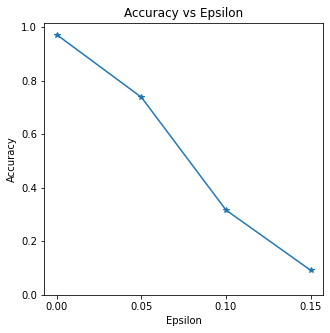

In [6]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xticks(np.arange(0, 0.17, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### 1.6 FGSM Visualization

Remember the idea of no free lunch? In this case, as epsilon increases, the test accuracy decreases **BUT** the perturbations become more easily perceptible. In reality, there is a tradeoff between accuracy degradation and perceptibility. Here, we show some examples of successful adversarial examples at each epsilon value. Each row of the plot shows a different epsilon value. The first row is the $\epsilon=0$ examples, which represent the original “clean” images with no perturbation. The title of each image shows the “original classification -> adversarial classification.” Notice the perturbations start to become evident at $\epsilon=0.1$ and are quite evident at $\epsilon=0.15$. However, in all cases, humans can still identify the correct class despite the added noise.

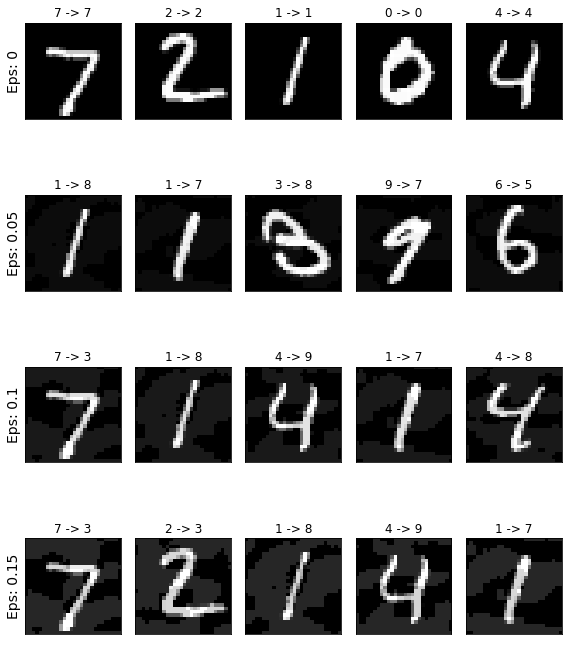

In [7]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### 1.7 Projected Gradient Descent (PGD) Adversarial Attack

PGD is a variant of FGSM. It uses random initialization for the input image, then repeatedly adds noise to it in multiple iterations to maximize the loss.

\begin{align}
&\eta = \text{Uniform} (-\epsilon, \epsilon), \\
&\delta_{PGD}^{T} = \Pi_{[-\epsilon, \epsilon]}[\eta +\alpha \cdot \operatorname{sign}\left(\nabla_{x + \eta +\delta^{T-1}} \ell(x + \eta +\delta^{T-1}, y;\theta)\right)].
\end{align}

The $T$ is the number of iterations, and $\Pi$ denotes the projection to ensure the noise magnitude.


**Implementation Step**

(1) Randomly initialize the perturbation based on uniform distribution between ($-\epsilon$,$\epsilon$).

(2) The attack backpropagates the gradient back to the input data and last iteration perturbation to calculate $\nabla_{x + \delta^{T-1}} \ell(\mathbf{x + \delta^{T-1}}, y; \mathbf{\theta})$. 

(3) Adjusting the input data by a small step size $\alpha$ in the direction $sign(\nabla_{x + \delta^{T-1}} \ell(\mathbf{x + \delta^{T-1}}, y; \mathbf{\theta})$. In the meantime, always keep the perturbation in range [$-\epsilon$,$\epsilon$] and $[0-\mathbf{x},1-\mathbf{x}]$.

(4) Call the **pgd_attack** function to generate adversarial example.

(5) Compute the model prediction on adversarial example.

(6) Check whether the prediction is correct.

**Function input:**

* Test model
* Input image $\mathbf{X}$
* Label $\mathbf{y}$
* Perturbation constraint $\epsilon$
* Perturbation step size $\alpha$
* Attack iterations $T$


**Function output:**
* Adversarial example $\delta$

In [8]:
'''TODO implement the PGD attack'''
def pgd_attack(model, X, y, epsilon, alpha, attack_iters):
    # (1) Randomly initialize the perturbation based on uniform distribution
    perturbation = torch.zeros_like(X).uniform_(-epsilon, epsilon)
    perturbation.data = torch.max(torch.min(1-X, perturbation.data), 0-X)
    for _ in range(attack_iters):
        perturbation.requires_grad = True

        # (2) Compute the perturbation gradient
        output = model(X + perturbation)
        loss = criterion(output, y)
        opt.zero_grad()
        loss.backward()
        grad = perturbation.grad.detach()

        # Check whether the attack is success
        I = output.max(1)[1] == y

        # (3) Compute and clip the range of perturbation
        perturbation.data[I] = torch.clamp(perturbation + alpha * torch.sign(grad), -epsilon, epsilon)[I]
        perturbation.data[I] = torch.max(torch.min(1-X, perturbation.data), 0-X)[I]

    return perturbation.detach()

def pgd_test(model, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    alpha = 0.03
    attack_iters = 10
    # Loop over all examples in test set
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        # Forward pass the data through the model
        output = model(X)
        init_pred = output.max(1, keepdim=True)[1]

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != y.item():
            continue

        '''TODO call the PGD attack'''

        # (4) Call PGD attack
        perturbation = pgd_attack(model, X, y, epsilon, alpha, attack_iters)

        # (5) Compute the model prediction on adversarial example
        output = model(X + perturbation)

        # (6) Check whether the prediction (final_pred) is correct
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == y.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tPGD Test Accuracy: {final_acc}")

## 2. Adversarial Training (AT) - Implement the FGSM-trained model.

The idea of AT is simple: just train on adversarial examples, which can be formulated as a min-max optimization problem:

\begin{align}
    \min _{\theta} \mathbb{E}_{(x, y) \sim \mathcal{D}}\left[\max _{\delta \in \Delta} \ell(x + \delta, y ; \theta)\right]
\end{align}

The *inner maximization* problem is to generate an adversarial perturbation $\delta$ within the $\epsilon$-ball around a given natural example $x$ that maximizes the classification loss.

The *outer minimization* problem is to find model parameters that minimize the loss on adversarial data that generated from the inner maximization.

In this case, we use FGSM to generate perturbation and train a model, as well as evaluation by FGSM and PGD attacks.

**Implementation Step**

(1) On-the-fly generate adversarial perturbation via FGSM attack.

(2) Optimize model on adversarial example $\mathbf{x} + \delta$.
 
(3) Evaluation the robustness of FGSM-trained model by FGSM and PGD attacks.

In [10]:
AT_model = mnist_net().to(device)
criterion = nn.CrossEntropyLoss()
AT_opt = torch.optim.SGD(AT_model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-4)
lr_steps = 10 * len(train_loader)
scheduler = torch.optim.lr_scheduler.CyclicLR(AT_opt, base_lr=0, max_lr=5e-3, step_size_up=lr_steps / 2, step_size_down=lr_steps / 2)
epsilon = 0.1


'''TODO using and evaluating the adversarial training'''
for epoch in range(10):
    train_loss = 0
    train_acc = 0
    train_n = 0
    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        AT_model.train()

        # (1) On-the-fly generate adversarial perturbation
        perturbation = fgsm_attack(AT_model, X, y, epsilon)

        # (2) Optimize model on adversarial example
        output = AT_model(X + perturbation)
        loss = criterion(output, y)
        AT_opt.zero_grad()
        loss.backward()
        AT_opt.step()

        scheduler.step()
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)

    train_loss = format((train_loss/train_n), ".4f")
    train_acc = format((train_acc/train_n), ".4f")
    print(f"Epoch: {epoch}\tTraining Loss: {train_loss}\tTraining Accuracy: {train_acc}")

AT_model.eval()

# (3) Evaluation the robustness of FGSM-trained
fgsm_test(AT_model, test_loader, epsilon)
pgd_test(AT_model, test_loader, epsilon)


Epoch: 0	Training Loss: 2.3253	Training Accuracy: 0.0004
Epoch: 1	Training Loss: 2.2804	Training Accuracy: 0.1941
Epoch: 2	Training Loss: 1.3154	Training Accuracy: 0.5804
Epoch: 3	Training Loss: 0.7705	Training Accuracy: 0.7504
Epoch: 4	Training Loss: 0.5461	Training Accuracy: 0.8277
Epoch: 5	Training Loss: 0.4183	Training Accuracy: 0.8695
Epoch: 6	Training Loss: 0.3491	Training Accuracy: 0.8917
Epoch: 7	Training Loss: 0.3065	Training Accuracy: 0.9053
Epoch: 8	Training Loss: 0.2784	Training Accuracy: 0.9135
Epoch: 9	Training Loss: 0.2593	Training Accuracy: 0.9199
Epsilon: 0.1	FGSM Test Accuracy: 0.9201
Epsilon: 0.1	PGD Test Accuracy: 0.9088
